![alt text](egm-logo.png "Title")

# Testing our Deep Learning model
Run inference on a yolov4 onnx model
This tutorial also includes preprocess and postprocess steps.


The model used and the Original Notebook can be found at https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/yolov4

## Step 1: Preprocessing
**Preprocessing**: Preparing our input image for the model

In [11]:
import cv2
import numpy as np
from onnx import numpy_helper
import onnx
import os
from PIL import Image
from matplotlib.pyplot import imshow
import onnxruntime as rt
from scipy import special
import colorsys
import random
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 10]

original image:


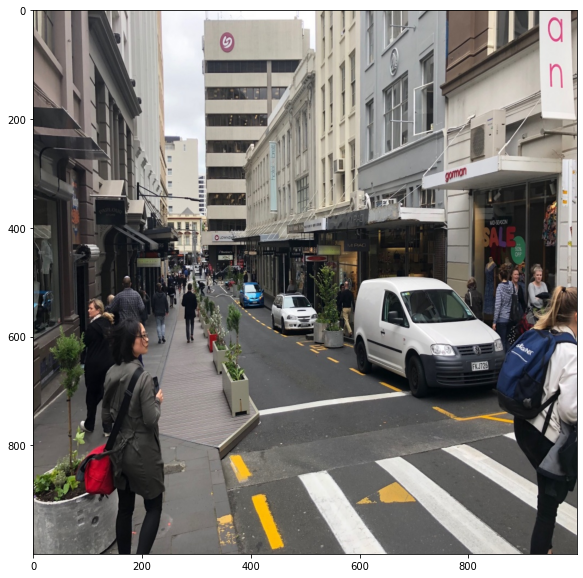

In [12]:
original_image = cv2.imread("street.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
print("original image:")
imshow(original_image)

In [13]:
def image_preprocess(image, target_size, gt_boxes=None):

    ih, iw = target_size
    h, w, _ = image.shape

    scale = min(iw/w, ih/h)
    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_padded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_padded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_padded = image_padded / 255.

    if gt_boxes is None:
        return image_padded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_padded, gt_boxes

Resized image:
Preprocessed image shape: (1, 416, 416, 3)


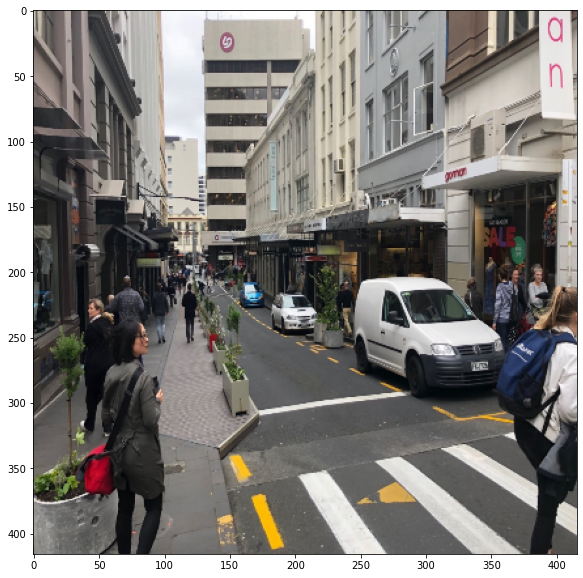

In [14]:
input_size = 416

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])

print("Resized image:")
imshow(np.asarray(image_data))

image_data = image_data[np.newaxis, ...].astype(np.float32)

print("Preprocessed image shape:",image_data.shape) # shape of the preprocessed input

## Step 2: Inference
**Inference:** Running our model on a given image

In [15]:
sess = rt.InferenceSession("yolov4.onnx")

outputs = sess.get_outputs()
output_names = list(map(lambda output: output.name, outputs))
input_name = sess.get_inputs()[0].name

detections = sess.run(output_names, {input_name: image_data})
print("Output shape:", list(map(lambda detection: detection.shape, detections)))

Output shape: [(1, 52, 52, 3, 85), (1, 26, 26, 3, 85), (1, 13, 13, 3, 85)]


## Step 3: Postprocessing
**Postprocessing:** Transform model output to valuable information

In [16]:

def get_anchors(anchors_path, tiny=False):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = np.array(anchors.split(','), dtype=np.float32)
    return anchors.reshape(3, 3, 2)

def postprocess_bbbox(pred_bbox, ANCHORS, STRIDES, XYSCALE=[1,1,1]):
    '''define anchor boxes'''
    for i, pred in enumerate(pred_bbox):
        conv_shape = pred.shape
        output_size = conv_shape[1]
        conv_raw_dxdy = pred[:, :, :, :, 0:2]
        conv_raw_dwdh = pred[:, :, :, :, 2:4]
        xy_grid = np.meshgrid(np.arange(output_size), np.arange(output_size))
        xy_grid = np.expand_dims(np.stack(xy_grid, axis=-1), axis=2)

        xy_grid = np.tile(np.expand_dims(xy_grid, axis=0), [1, 1, 1, 3, 1])
        xy_grid = xy_grid.astype(float)

        pred_xy = ((special.expit(conv_raw_dxdy) * XYSCALE[i]) - 0.5 * (XYSCALE[i] - 1) + xy_grid) * STRIDES[i]
        pred_wh = (np.exp(conv_raw_dwdh) * ANCHORS[i])
        pred[:, :, :, :, 0:4] = np.concatenate([pred_xy, pred_wh], axis=-1)

    pred_bbox = [np.reshape(x, (-1, np.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = np.concatenate(pred_bbox, axis=0)
    return pred_bbox


def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):
    '''remove boundary boxs with a low detection probability'''
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes that are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def bboxes_iou(boxes1, boxes2):
    '''calculate the Intersection Over Union value'''
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def read_class_names(class_file_name):
    '''loads class name from a file'''
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

def draw_bbox(image, bboxes, classes=read_class_names("coco.names"), show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)
            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

In [17]:
ANCHORS = "./yolov4_anchors.txt"
STRIDES = [8, 16, 32]
XYSCALE = [1.2, 1.1, 1.05]

ANCHORS = get_anchors(ANCHORS)
STRIDES = np.array(STRIDES)

pred_bbox = postprocess_bbbox(detections, ANCHORS, STRIDES, XYSCALE)
bboxes = postprocess_boxes(pred_bbox, original_image_size, input_size, 0.25)
image_before_nms = draw_bbox(original_image.copy(), bboxes)

## Step 4: Visualise Detections

###  Before NMS:

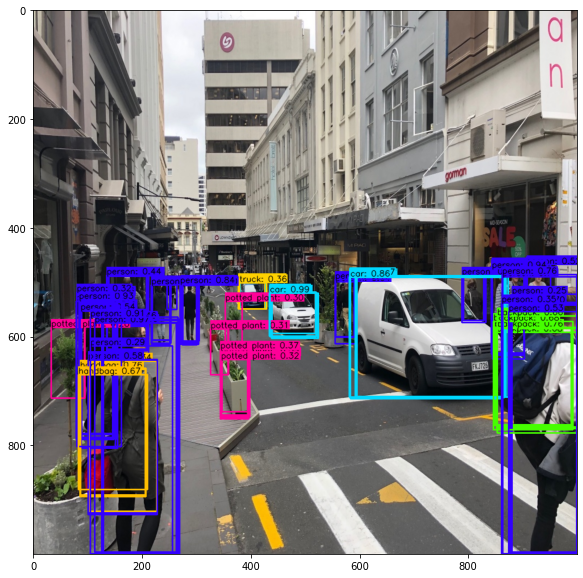

In [18]:
image_before_nms = Image.fromarray(image_before_nms)
image_before_nms.show()

imshow(np.asarray(image_before_nms))

### After NMS:

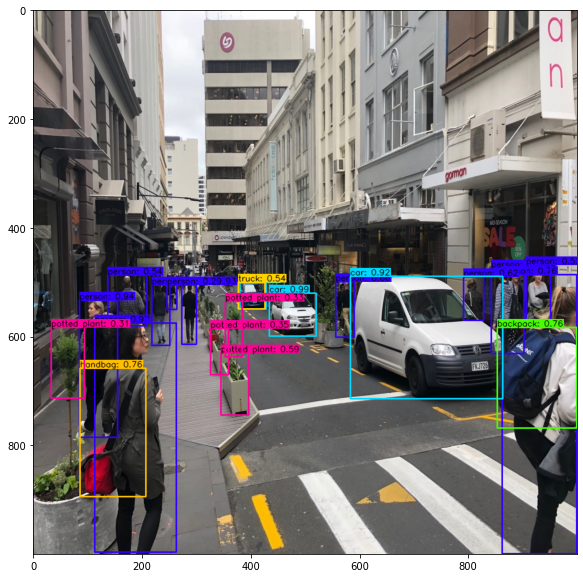

In [19]:
bboxes = nms(bboxes, 0.213, method='nms')
image = draw_bbox(original_image, bboxes)

image = Image.fromarray(image)
image.show()

imshow(np.asarray(image))